In [27]:
import pandas as pd
import numpy as np

In [28]:
import _pickle as cPickle
from pathlib import Path

def dumpPickle(fileName, content):
    pickleFile = open(fileName, 'wb')
    cPickle.dump(content, pickleFile, -1)
    pickleFile.close()

def loadPickle(fileName):    
    file = open(fileName, 'rb')
    content = cPickle.load(file)
    file.close()
    
    return content
    
def pickleExists(fileName):
    file = Path(fileName)
    
    if file.is_file():
        return True
    
    return False

In [29]:
wordPickleName = '../data/wordsDf.pkl'
df = loadPickle(wordPickleName)

In [30]:
df.head()

,text,isAnswer,titleId,paragrapghId,sentenceId,wordCount,NER,POS,TAG,DEP,shape
0,Architecturally,False,0,0,0.0,1,None,ADV,RB,advmod,Xxxxx
1,school,False,0,0,0.0,1,None,NOUN,NN,nsubj,xxxx
2,Catholic,False,0,0,0.0,1,NORP,None,None,None,Xxxxx
3,character,False,0,0,0.0,1,None,NOUN,NN,dobj,xxxx
4,Atop,False,0,0,1.0,1,None,ADP,IN,prep,Xxxx


In [31]:
columnsToEncode = ['NER', 'POS', "TAG", 'DEP']

In [32]:
for column in columnsToEncode:
    print(column)
    one_hot = pd.get_dummies(df[column])
    one_hot = one_hot.add_prefix(column + '_')

    df = df.drop(column, axis = 1)
    df = df.join(one_hot)

NER
POS
TAG
DEP


In [33]:
df.head()

,text,isAnswer,titleId,paragrapghId,sentenceId,wordCount,shape,NER_CARDINAL,NER_DATE,NER_EVENT,...,DEP_nsubjpass,DEP_nummod,DEP_oprd,DEP_pcomp,DEP_pobj,DEP_poss,DEP_predet,DEP_prep,DEP_relcl,DEP_xcomp
0,Architecturally,False,0,0,0.0,1,Xxxxx,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,school,False,0,0,0.0,1,xxxx,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Catholic,False,0,0,0.0,1,Xxxxx,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,character,False,0,0,0.0,1,xxxx,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Atop,False,0,0,1.0,1,Xxxx,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [34]:
columnsToDrop = ['text', 'titleId', 'paragrapghId', 'sentenceId', 'shape']

In [35]:
df = df.drop(columnsToDrop, axis = 1)

In [36]:
df.head()

,isAnswer,wordCount,NER_CARDINAL,NER_DATE,NER_EVENT,NER_FAC,NER_GPE,NER_LANGUAGE,NER_LAW,NER_LOC,...,DEP_nsubjpass,DEP_nummod,DEP_oprd,DEP_pcomp,DEP_pobj,DEP_poss,DEP_predet,DEP_prep,DEP_relcl,DEP_xcomp
0,False,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,False,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,False,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,False,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,False,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [37]:
from sklearn.model_selection import train_test_split

x_data = df.drop(labels=['isAnswer'], axis=1)
y_data = df['isAnswer']

x_train, x_test, y_train, y_test = train_test_split(x_data, 
                                                    y_data, 
                                                    test_size=0.1, 
                                                    random_state=4)

In [38]:
print(len(x_train))
print(len(y_train))
print(len(x_test))
print(len(y_test))

7749
7749
862
862


In [39]:
y_test.head()

6734    False
7872    False
2335    False
1939    False
7360    False
Name: isAnswer, dtype: bool

In [40]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()

In [41]:
predictor = gnb.fit(x_train, y_train)
y_pred = predictor.predict(x_test)

In [42]:
correctCount = (y_test == y_pred).sum()

print('Correctly guessed:', '{:.2f}%'.format((correctCount / len(y_test)) * 100))

Correctly guessed: 31.55%


In [43]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)

array([[236, 588],
       [  2,  36]], dtype=int64)

In [44]:
import itertools
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          figsize=(9, 7)):
    matrix = confusion_matrix(y_true, y_pred)

    if normalize:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=figsize)
    plt.imshow(matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], fmt),
                 horizontalalignment="center",
                 size=int((figsize[0] / 10) * 38),
                 color="white" if matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

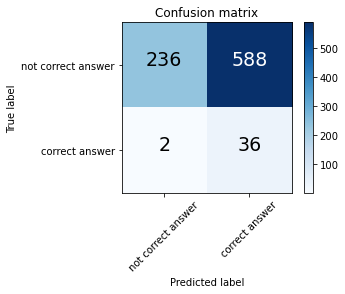

In [45]:
plot_confusion_matrix(y_test, y_pred, ['not correct answer', 'correct answer'], figsize=(5, 4))

In [46]:
y_test.value_counts()

False    824
True      38
Name: isAnswer, dtype: int64

In [47]:
y_pred_Series = pd.Series(y_pred)

In [48]:
y_pred_Series.value_counts()

True     624
False    238
dtype: int64

In [49]:
predictorPickleName = '../data/nb-predictor.pkl'
dumpPickle(predictorPickleName, predictor)